<a href="https://colab.research.google.com/github/cagdastopcu/omission-of-visual-stimuli/blob/main/Trying_to_get_meandFF_between_imag0_pres_JG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The usual import step:

In [1]:
!python -m pip install --upgrade pip
!pip install mindscope_utilities --upgrade

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Here are the Allen packages:
import mindscope_utilities
import mindscope_utilities.visual_behavior_ophys as ophys
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

In [3]:
data_storage_directory = "/temp" # Note: this path must exist on your local drive
cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_storage_directory)

# Setup the tables for the sessions and experiments:
session_table = cache.get_ophys_session_table()
experiment_table = cache.get_ophys_experiment_table()

ophys_session_table.csv: 100%|██████████| 165k/165k [00:00<00:00, 1.47MMB/s] 
behavior_session_table.csv: 100%|██████████| 885k/885k [00:00<00:00, 5.81MMB/s] 
ophys_experiment_table.csv: 100%|██████████| 336k/336k [00:00<00:00, 2.78MMB/s] 


we want this 'full_etr' dataset:

In [4]:
def get_cell_type_index(cell_type,session_table):

    """Get the indexes of the Allen sessions that use a particular cre line.
    
    Args:
      cell_type:  a string of the name of the cre line you want. This uses regex so you can try to be less descriptive, like 'sst' is good enoguh for Sst-IRES-cre.
      session_table: The table containing the sessions from Allen.

    Returns:
      ix (1D array): An index of sessions that use that cre line.
    """

    # Look through the cre_line collumn and see if the cell_type string is contained in the output, then write down the index.
    ix = session_table.cre_line.str.contains(cell_type,regex=True).index

    return ix

test_ix = get_cell_type_index('sst',session_table)
print(test_ix)

Int64Index([ 951410079,  952430817,  954954402,  955775716,  957020350,
             958105827,  958772311,  959458018,  993727065,  993984066,
            ...
            1050633071, 1050946706, 1051120218,  960475393,  961180142,
             961665529,  962736894,  963496285,  964660947,  965319434],
           dtype='int64', name='ophys_session_id', length=551)


In [5]:
ophys_session_id = test_ix[0]
session_table.loc[ophys_session_id]

experiments = {}
ophys_experiment_ids = session_table.loc[ophys_session_id]['ophys_experiment_id']
for ophys_experiment_id in ophys_experiment_ids:
    experiments[ophys_experiment_id] = cache.get_behavior_ophys_experiment(ophys_experiment_id)

behavior_ophys_experiment_951980471.nwb: 100%|██████████| 264M/264M [00:09<00:00, 28.9MMB/s]
behavior_ophys_experiment_951980473.nwb: 100%|██████████| 249M/249M [00:08<00:00, 29.3MMB/s]
behavior_ophys_experiment_951980475.nwb: 100%|██████████| 249M/249M [00:08<00:00, 28.5MMB/s]
behavior_ophys_experiment_951980479.nwb: 100%|██████████| 270M/270M [00:09<00:00, 29.1MMB/s]
behavior_ophys_experiment_951980481.nwb: 100%|██████████| 270M/270M [00:09<00:00, 28.3MMB/s]
behavior_ophys_experiment_951980484.nwb: 100%|██████████| 242M/242M [00:08<00:00, 29.4MMB/s]
behavior_ophys_experiment_951980486.nwb: 100%|██████████| 249M/249M [00:08<00:00, 27.7MMB/s]


In [6]:
neural_data = []
for ophys_experiment_id in tqdm(experiments.keys()): #tqdm is a package that shows progress bars for items that are iterated over
    this_experiment = experiments[ophys_experiment_id]
    this_experiment_neural_data = ophys.build_tidy_cell_df(this_experiment)
    
    # add some columns with metadata for the experiment
    metadata_keys = [
        'ophys_experiment_id',
        'ophys_session_id',
        'targeted_structure',
        'imaging_depth',
        'equipment_name',
        'cre_line',
        'mouse_id',
        'sex',
    ]
    for metadata_key in metadata_keys:
        this_experiment_neural_data[metadata_key] = this_experiment.metadata[metadata_key]
        
    # append the data for this experiment to a list
    neural_data.append(this_experiment_neural_data)
    
# concatate the list of dataframes into a single dataframe
neural_data = pd.concat(neural_data)

neural_data

100%|██████████| 7/7 [00:46<00:00,  6.58s/it]


,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.26356,0.936573,0.000000,0.000000,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
1,9.35677,0.582486,0.000000,0.000000,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
2,9.44998,1.296005,0.556873,0.185215,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
3,9.54318,0.844898,0.000000,0.163452,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
4,9.63639,1.181188,0.467264,0.267750,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48311,4513.50871,2.012210,0.000000,0.295667,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48312,4513.60195,2.238623,0.513076,0.326969,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48313,4513.69518,1.749840,0.000000,0.219440,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48314,4513.78842,1.868406,0.416648,0.266907,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F


In [7]:
stimulus_table = experiments[ophys_experiment_ids[0]].stimulus_presentations
stimulus_table

,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
stimulus_presentations_id,,,,,,,,,,,
0,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False
1,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False
2,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False
3,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False
4,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False
...,...,...,...,...,...,...,...,...,...,...,...
4796,0.25020,233857.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4628,False,233842,3909.81737,3910.06757,False
4797,0.25021,233902.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4629,False,233887,3910.56798,3910.81819,False
4798,0.25020,233947.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4630,False,233932,3911.31860,3911.56880,False


In [8]:
full_etr = []
# iterate over each unique cell
for cell_specimen_id in tqdm(neural_data['cell_specimen_id'].unique()):
    # calculate the event triggered response for this cell to every stimulus
    full_etr_this_cell = mindscope_utilities.event_triggered_response(
        neural_data.query('cell_specimen_id == @cell_specimen_id'),
        t = 'timestamps',
        y = 'dff',
        event_times = stimulus_table['start_time'],
        t_before = 0,
        t_after = 0.75,
        output_sampling_rate = 30 
    )
    # add a column identifying the cell_specimen_id
    full_etr_this_cell['cell_specimen_id'] = cell_specimen_id
    # append to our list
    full_etr.append(full_etr_this_cell)

# concatenate our list of dataframes into a single dataframe
full_etr = pd.concat(full_etr)

# cast these numeric columns to int and float, respectively 
full_etr['event_number'] = full_etr['event_number'].astype(int)
full_etr['event_time'] = full_etr['event_number'].astype(float)
full_etr.rename(columns = {'event_time': 'stimulus_presentations_id'}, inplace=True)

100%|██████████| 88/88 [05:31<00:00,  3.77s/it]


In [9]:
full_etr

,time,dff,event_number,stimulus_presentations_id,cell_specimen_id
0,0.000000,1.017334,0,0.0,1086613265
1,0.034091,1.017334,0,0.0,1086613265
2,0.068182,1.017334,0,0.0,1086613265
3,0.102273,1.022310,0,0.0,1086613265
4,0.136364,1.029972,0,0.0,1086613265
...,...,...,...,...,...
110418,0.613636,0.021896,4800,4800.0,1086612827
110419,0.647727,-0.006772,4800,4800.0,1086612827
110420,0.681818,0.012321,4800,4800.0,1086612827
110421,0.715909,0.031414,4800,4800.0,1086612827


In [10]:
average_responses = full_etr.groupby(['cell_specimen_id','stimulus_presentations_id'])[['dff']].mean().reset_index().merge(
    stimulus_table,
    on = 'stimulus_presentations_id',
    how = 'left'
)
average_responses

,cell_specimen_id,stimulus_presentations_id,dff,duration,end_frame,image_index,image_name,image_set,index,omitted,start_frame,start_time,stop_time,is_change
0,1086606974,0.0,-0.644137,0.25020,18001.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,17986,309.27537,309.52557,False
1,1086606974,1.0,-0.104356,0.25021,18046.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,18031,310.02598,310.27619,False
2,1086606974,2.0,-0.043796,0.25020,18091.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,18076,310.77660,311.02680,False
3,1086606974,3.0,0.162058,0.25019,18136.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,18121,311.52721,311.77740,False
4,1086606974,4.0,0.052421,0.25024,18181.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4,False,18166,312.27782,312.52806,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
422483,1086623929,4796.0,0.013520,0.25020,233857.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4628,False,233842,3909.81737,3910.06757,False
422484,1086623929,4797.0,0.010339,0.25021,233902.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4629,False,233887,3910.56798,3910.81819,False
422485,1086623929,4798.0,-0.038199,0.25020,233947.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4630,False,233932,3911.31860,3911.56880,False
422486,1086623929,4799.0,0.016099,0.25018,233992.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,4631,False,233977,3912.06921,3912.31939,False


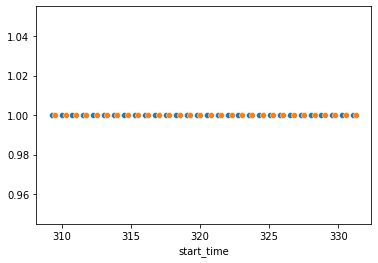

In [11]:

sns.scatterplot(y =np.ones(30), x= average_responses.start_time[:30])
sns.scatterplot(y =np.ones(30), x= average_responses.stop_time[:30])


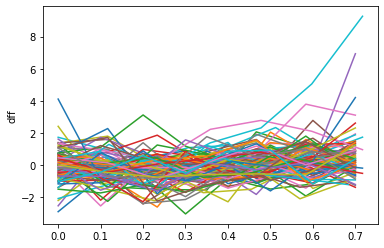

In [178]:
timepad = .1; # seconds

cells = average_responses.cell_specimen_id.unique()
past = sns.color_palette("pastel",len(cells))

cc = -1
for c in cells[:1]:
  cc+=1
  subset = average_responses[(average_responses['cell_specimen_id'] == c)]
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = [];
  #for i in range(len(subset.start_time.unique())-1):
  for i in range(100):
    t2 = subset.iloc[i+1].start_time+timepad 
    t1 = subset.iloc[i].stop_time-timepad 
    dff = []
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    t = np.linspace(
                t1,
                t2,
                len(dff)
            )
    
    sns.lineplot(x = t - min(t), y =dff)


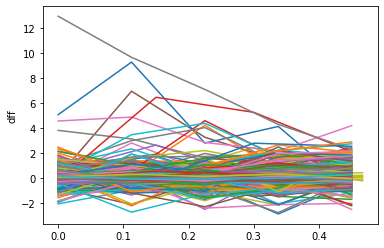

In [182]:
cells = average_responses.cell_specimen_id.unique()
past = sns.color_palette("pastel",len(cells))

cc = -1
for c in cells[:7]:
  cc+=1
  subset = average_responses[(average_responses['cell_specimen_id'] == c)]
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = [];
  #for i in range(len(subset.start_time.unique())-1):
  for i in range(200):
    t1 = average_responses.start_time[i]-timepad
    t2 = average_responses.stop_time[i]+timepad
    dff = []
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    t = np.linspace(
                t1,
                t2,
                len(dff)
            )
    
    sns.lineplot(x = t - min(t), y =dff)


In [148]:
what the fuck

,timestamps,dff,events,filtered_events,cell_roi_id,cell_specimen_id,ophys_experiment_id,ophys_session_id,targeted_structure,imaging_depth,equipment_name,cre_line,mouse_id,sex
0,9.26356,0.936573,0.000000,0.000000,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
1,9.35677,0.582486,0.000000,0.000000,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
2,9.44998,1.296005,0.556873,0.185215,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
3,9.54318,0.844898,0.000000,0.163452,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
4,9.63639,1.181188,0.467264,0.267750,1080743723,1086613265,951980471,951410079,VISp,150,MESO.1,Sst-IRES-Cre,457841,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48311,4513.50871,2.012210,0.000000,0.295667,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48312,4513.60195,2.238623,0.513076,0.326969,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48313,4513.69518,1.749840,0.000000,0.219440,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F
48314,4513.78842,1.868406,0.416648,0.266907,1080742704,1086612827,951980486,951410079,VISl,300,MESO.1,Sst-IRES-Cre,457841,F


In [221]:
def get_mean_gray_resp(average_responses,neural_data,c):
  subset = average_responses[(average_responses['cell_specimen_id'] == c)]
  nd = neural_data[(neural_data['cell_specimen_id'] == c)]

  holder = []

  for i in range(len(subset.start_time.unique())-1):
    t2 = subset.start_time[i+1]
    t1 = subset.stop_time[i]
    dff = nd.dff[(nd.timestamps >= t1) & (nd.timestamps <= t2)]
    holder = np.concatenate([holder, dff.to_numpy().T], axis=0)

  return np.mean(holder)

cells = average_responses.cell_specimen_id.unique()
a = get_mean_gray_resp(average_responses,neural_data,cells[0])

a

0.1869288606861286